# 线性回归的简洁实现
:label:`sec_linear_concise`

在过去的几年里，出于对深度学习强烈的兴趣，
许多公司、学者和业余爱好者开发了各种成熟的开源框架。
这些框架可以自动化基于梯度的学习算法中重复性的工作。
在 :numref:`sec_linear_scratch`中，我们只运用了：
（1）通过张量来进行数据存储和线性代数；
（2）通过自动微分来计算梯度。
实际上，由于数据迭代器、损失函数、优化器和神经网络层很常用，
现代深度学习库也为我们实现了这些组件。

本节将介绍如何(**通过使用深度学习框架来简洁地实现**)
 :numref:`sec_linear_scratch`中的(**线性回归模型**)。

## 生成数据集

与 :numref:`sec_linear_scratch`中类似，我们首先[**生成数据集**]。


In [17]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

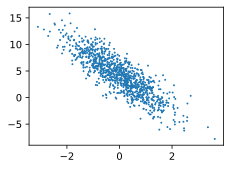

In [19]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## 读取数据集

我们可以[**调用框架中现有的API来读取数据**]。
我们将`features`和`labels`作为API的参数传递，并通过数据迭代器指定`batch_size`。
此外，布尔值`is_train`表示是否希望数据迭代器对象在每个迭代周期内打乱数据。


In [8]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [10]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

使用`data_iter`的方式与我们在 :numref:`sec_linear_scratch`中使用`data_iter`函数的方式相同。为了验证是否正常工作，让我们读取并打印第一个小批量样本。
与 :numref:`sec_linear_scratch`不同，这里我们使用`iter`构造Python迭代器，并使用`next`从迭代器中获取第一项。


In [13]:
next(iter(data_iter))

[tensor([[-1.5582, -0.3795],
         [ 0.1943, -1.2747],
         [-0.5963, -0.1379],
         [ 0.4978, -0.0281],
         [-0.2017,  0.5761],
         [ 1.7374,  0.8493],
         [ 0.4862,  0.0857],
         [-2.0678, -0.7197],
         [-0.3961,  0.0579],
         [ 0.7383, -1.3659]]),
 tensor([[ 2.3695],
         [ 8.9099],
         [ 3.4852],
         [ 5.2978],
         [ 1.8513],
         [ 4.7801],
         [ 4.8816],
         [ 2.4982],
         [ 3.2203],
         [10.3114]])]

## 定义模型

当我们在 :numref:`sec_linear_scratch`中实现线性回归时，
我们明确定义了模型参数变量，并编写了计算的代码，这样通过基本的线性代数运算得到输出。
但是，如果模型变得更加复杂，且当我们几乎每天都需要实现模型时，自然会想简化这个过程。
这种情况类似于为自己的博客从零开始编写网页。
做一两次是有益的，但如果每个新博客就需要工程师花一个月的时间重新开始编写网页，那并不高效。

对于标准深度学习模型，我们可以[**使用框架的预定义好的层**]。这使我们只需关注使用哪些层来构造模型，而不必关注层的实现细节。
我们首先定义一个模型变量`net`，它是一个`Sequential`类的实例。
`Sequential`类将多个层串联在一起。
当给定输入数据时，`Sequential`实例将数据传入到第一层，
然后将第一层的输出作为第二层的输入，以此类推。
在下面的例子中，我们的模型只包含一个层，因此实际上不需要`Sequential`。
但是由于以后几乎所有的模型都是多层的，在这里使用`Sequential`会让你熟悉“标准的流水线”。

回顾 :numref:`fig_single_neuron`中的单层网络架构，
这一单层被称为*全连接层*（fully-connected layer），
因为它的每一个输入都通过矩阵-向量乘法得到它的每个输出。


在PyTorch中，全连接层在`Linear`类中定义。
值得注意的是，我们将两个参数传递到`nn.Linear`中。
第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。


In [6]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

## (**初始化模型参数**)

在使用`net`之前，我们需要初始化模型参数。
如在线性回归模型中的权重和偏置。
深度学习框架通常有预定义的方法来初始化参数。
在这里，我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样，
偏置参数将初始化为零。


正如我们在构造`nn.Linear`时指定输入和输出尺寸一样，
现在我们能直接访问参数以设定它们的初始值。
我们通过`net[0]`选择网络中的第一个图层，
然后使用`weight.data`和`bias.data`方法访问参数。
我们还可以使用替换方法`normal_`和`fill_`来重写参数值。


In [7]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 定义损失函数


[**计算均方误差使用的是`MSELoss`类，也称为平方$L_2$范数**]。
默认情况下，它返回所有样本损失的平均值。


In [8]:
loss = nn.MSELoss()

## 定义优化算法


小批量随机梯度下降算法是一种优化神经网络的标准工具，
PyTorch在`optim`模块中实现了该算法的许多变种。
当我们(**实例化一个`SGD`实例**)时，我们要指定优化的参数
（可通过`net.parameters()`从我们的模型中获得）以及优化算法所需的超参数字典。
小批量随机梯度下降只需要设置`lr`值，这里设置为0.03。


In [9]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 训练

通过深度学习框架的高级API来实现我们的模型只需要相对较少的代码。
我们不必单独分配参数、不必定义我们的损失函数，也不必手动实现小批量随机梯度下降。
当我们需要更复杂的模型时，高级API的优势将大大增加。
当我们有了所有的基本组件，[**训练过程代码与我们从零开始实现时所做的非常相似**]。

回顾一下：在每个迭代周期里，我们将完整遍历一次数据集（`train_data`），
不停地从中获取一个小批量的输入和相应的标签。
对于每一个小批量，我们会进行以下步骤:

* 通过调用`net(X)`生成预测并计算损失`l`（前向传播）。
* 通过进行反向传播来计算梯度。
* 通过调用优化器来更新模型参数。

为了更好的衡量训练效果，我们计算每个迭代周期后的损失，并打印它来监控训练过程。


In [10]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000248
epoch 2, loss 0.000103
epoch 3, loss 0.000103


下面我们[**比较生成数据集的真实参数和通过有限数据训练获得的模型参数**]。
要访问参数，我们首先从`net`访问所需的层，然后读取该层的权重和偏置。
正如在从零开始实现中一样，我们估计得到的参数与生成数据的真实参数非常接近。


In [11]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0010, -0.0003])
b的估计误差： tensor([-0.0003])


## 小结


* 我们可以使用PyTorch的高级API更简洁地实现模型。
* 在PyTorch中，`data`模块提供了数据处理工具，`nn`模块定义了大量的神经网络层和常见损失函数。
* 我们可以通过`_`结尾的方法将参数替换，从而初始化参数。


## 练习

1. 如果将小批量的总损失替换为小批量损失的平均值，需要如何更改学习率？
1. 查看深度学习框架文档，它们提供了哪些损失函数和初始化方法？用Huber损失代替原损失，即
    $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \text{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \text{ 其它情况}\end{cases}$$
1. 如何访问线性回归的梯度？


[Discussions](https://discuss.d2l.ai/t/1781)
